In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import urllib.request
import random
import string
# --- VISUALIZZAZIONE DI VERIFICA (Matplotlib) ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURAZIONE ---
IMG_H, IMG_W = 128, 128
PATCH_SIZE = 8  # La dimensione della tua cella (e del carattere)
FONT_URL = "http://viznut.fi/unscii/unscii-8.ttf"
FONT_FILENAME = "unscii-8.ttf"

def download_font():
    if not os.path.exists(FONT_FILENAME):
        print(f"Scaricamento font {FONT_FILENAME} per pixel-perfect rendering...")
        try:
            urllib.request.urlretrieve(FONT_URL, FONT_FILENAME)
            print("Download completato.")
        except Exception as e:
            print(f"Errore download: {e}. Assicurati di avere 'unscii-8.ttf' nella cartella.")

class GridOCRDataset(Dataset):
    def __init__(self, num_samples, img_h=128, img_w=128, patch_size=8):
        self.num_samples = num_samples
        self.img_h = img_h
        self.img_w = img_w
        self.patch_size = patch_size
        
        # Dimensioni della griglia (es. 128/8 = 16 righe/colonne)
        self.grid_rows = img_h // patch_size
        self.grid_cols = img_w // patch_size
        self.total_patches = self.grid_rows * self.grid_cols
        
        # Vocabolario esteso (ASCII + Esempio UTF Latin-1)
        # Nota: Unscii supporta molto altro, qui metto un subset per demo
        self.chars = [' '] + list(string.ascii_letters + string.digits + string.punctuation + "ÀÈÉÌÒÙàèéìòùÇçÑñ")
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

        # Caricamento Font
        # size=8 con questo font garantisce 1 pixel font = 1 pixel immagine
        try:
            self.font = ImageFont.truetype(FONT_FILENAME, size=patch_size)
        except OSError:
            print("Font non trovato, uso default (l'allineamento potrebbe rompersi!)")
            self.font = ImageFont.load_default()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 1. Canvas nero
        image = Image.new('L', (self.img_w, self.img_h), color=0)
        draw = ImageDraw.Draw(image)
        
        # 2. Target tensor (inizializzato a 0 = SPAZIO)
        target = torch.zeros((self.total_patches,), dtype=torch.long)
        
        patch_idx = 0
        """ for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                # Densità del testo: 50% di probabilità che la cella sia piena
                if random.random() > 0.5:
                    char = random.choice(self.chars[1:]) # Skip spazio
                    
                    # Coordinate esatte
                    x = c * self.patch_size
                    y = r * self.patch_size
                    
                    # Disegno
                    draw.text((x, y), char, fill=255, font=self.font)
                    
                    # Label
                    target[patch_idx] = self.char_to_idx[char]
                
                patch_idx += 1 """
        
        word = "Ciao come; è và?"
        draw.text((0, 0), word, fill=255, font=self.font)
        for char in word:
            target[patch_idx] = self.char_to_idx[char]
            patch_idx += 1

        
        # Normalizzazione [0, 1] e aggiunta canale
        img_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        
        return img_tensor, target

In [2]:
import textwrap


def ensure_font():
    if not os.path.exists(FONT_FILENAME):
        print("Scaricamento font Unscii-8...")
        urllib.request.urlretrieve(FONT_URL, FONT_FILENAME)

class DocumentRenderer:
    def __init__(self, img_h=128, img_w=128, patch_size=8):
        ensure_font()
        self.img_h = img_h
        self.img_w = img_w
        self.patch_size = patch_size
        
        # Calcolo dimensioni griglia (es. 16x16 caratteri)
        self.rows = img_h // patch_size
        self.cols = img_w // patch_size
        self.patches_per_page = self.rows * self.cols
        
        # Caricamento Font
        self.font = ImageFont.truetype(FONT_FILENAME, size=patch_size)
        
        # Vocabolario (0 riservato per SPAZIO/Padding)
        # Aggiungiamo caratteri comuni per documenti
        self.chars = [' '] + list(string.ascii_letters + string.digits + string.punctuation + "\n")
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

    def text_to_pages(self, long_text):
        """
        Input: Stringa lunga.
        Output: Tensor Immagini, Tensor Labels
        Logica: Character-level wrapping (spezza le parole).
        """
        # 1. Pulizia base
        text = long_text.replace('\t', '  ') # Tab -> 2 spazi
        # Sostituisci caratteri non supportati con '?'
        text = ''.join([c if c in self.char_to_idx else '?' for c in text])
        
        # 2. Creazione delle linee "Visive" (Slicing brutale)
        # Prima dividiamo per i \n originali per rispettare i paragrafi
        original_paragraphs = text.split('\n')
        visual_lines = []
        
        for p in original_paragraphs:
            if len(p) == 0:
                # Se c'era un a capo vuoto, aggiungiamo una riga vuota
                visual_lines.append(" " * self.cols)
                continue
            
            # --- IL CUORE DEL CAMBIAMENTO ---
            # Affettiamo la stringa ogni 'self.cols' caratteri
            # Esempio: "CIAOCOMESTAI" (cols=4) -> "CIAO", "COME", "STAI"
            chunks = [p[i : i + self.cols] for i in range(0, len(p), self.cols)]
            visual_lines.extend(chunks)

        # 3. Paginazione (Raggruppiamo le linee in pagine)
        # Dividiamo la lista visual_lines in gruppi di 'self.rows'
        pages_of_lines = [visual_lines[i : i + self.rows] for i in range(0, len(visual_lines), self.rows)]
        
        n_pages = len(pages_of_lines)
        images_tensor = torch.zeros((n_pages, 1, self.img_h, self.img_w), dtype=torch.float32)
        labels_tensor = torch.zeros((n_pages, self.patches_per_page), dtype=torch.long)
        
        # 4. Rendering
        for p_idx, lines in enumerate(pages_of_lines):
            img = Image.new('L', (self.img_w, self.img_h), color=0)
            draw = ImageDraw.Draw(img)
            
            for r, line in enumerate(lines):
                # Padding manuale con spazi se la riga è l'ultima del paragrafo e non riempie la larghezza
                line = line.ljust(self.cols)
                
                for c, char in enumerate(line):
                    # Disegno Pixel
                    x, y = c * self.patch_size, r * self.patch_size
                    if char != ' ':
                        draw.text((x, y), char, fill=255, font=self.font)
                    
                    # Label
                    flat_idx = r * self.cols + c
                    if char in self.char_to_idx:
                        labels_tensor[p_idx, flat_idx] = self.char_to_idx[char]
            
            images_tensor[p_idx, 0] = torch.from_numpy(np.array(img)) / 255.0
            
        return images_tensor, labels_tensor
# --- UTILIZZO E VISUALIZZAZIONE ---

# 1. Testo di esempio (DocString di Python o Lorem Ipsum)
sample_document = """
VISION TRANSFORMER PROJECT
--------------------------
Obiettivo: OCR su griglia.
Font: Unscii-8 (Monospace).

Questo testo e' generato automaticamente per testare la capacita' del sistema di gestire il wrapping.
Se scrivo una frase molto lunga, questa dovrebbe andare a capo automaticamente senza spezzare le parole a meta', grazie alla libreria textwrap di Python.

Formula: E = mc^2
Codice:
def hello():
    print("World")

Fine del documento.
"""

# 2. Inizializza Renderer
renderer = DocumentRenderer(img_h=256, img_w=256, patch_size=8)
print(f"Griglia: {renderer.rows} righe x {renderer.cols} colonne per pagina.")

# 3. Genera Immagini
images, labels = renderer.text_to_pages(sample_document)

images[0]

Scaricamento font Unscii-8...
Griglia: 32 righe x 32 colonne per pagina.


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [3]:
len(labels[0])

1024

In [4]:
len(sample_document)

447

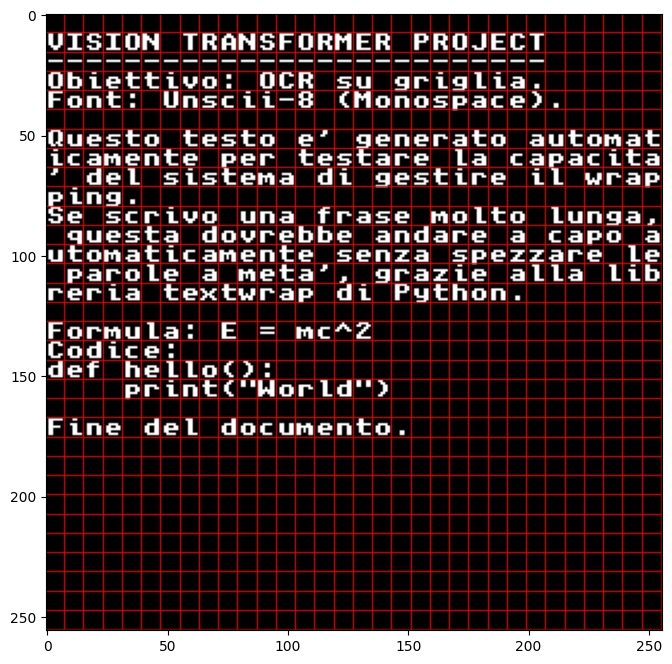

In [5]:
# Convertiamo per visualizzare
img_np = images[0].squeeze().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_np, cmap='gray')

# Disegniamo la griglia rossa sopra per vedere se combacia con i caratteri
# Se il carattere è perfettamente dentro il quadrato rosso, il ViT funzionerà.
for r in range(renderer.rows):
    for c in range(renderer.cols):
        rect = patches.Rectangle(
            (c * PATCH_SIZE - 1, r * PATCH_SIZE - 1), # -0.5 per centrare visivamente sulle linee pixel
            PATCH_SIZE, PATCH_SIZE, 
            linewidth=1, edgecolor='r', facecolor='none', alpha=0.5
        )
        ax.add_patch(rect)
        
plt.show()

In [11]:
import zlib
import numpy as np
from PIL import Image
import math
import os

class TextToImage:
    def __init__(self, width=128, height=128):
        self.width = width
        self.height = height
        self.total_pixels = width * height
        self.header_size = 4  # Bytes reserved for data length
        
    def _bytes_to_image(self, data_bytes, output_filename):
        """Helper: Converts a byte stream into a grayscale PNG."""
        # Check capacity
        if len(data_bytes) > self.total_pixels:
            raise ValueError(f"Data overflow! {len(data_bytes)} bytes vs {self.total_pixels} pixels.")
            
        # Pad with zeros (Black) to fill canvas
        padding = self.total_pixels - len(data_bytes)
        padded_data = data_bytes + b'\x00' * padding
        
        # Convert to Numpy Array -> Image
        pixel_array = np.frombuffer(padded_data, dtype=np.uint8)
        pixel_array = pixel_array.reshape((self.height, self.width))
        
        img = Image.fromarray(pixel_array, mode='L')
        img.save(output_filename)
        print(f"[{output_filename}] Saved successfully.")

    def _image_to_bytes(self, image_path):
        """Helper: Converts a PNG back into a raw byte stream."""
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"{image_path} does not exist.")
            
        img = Image.open(image_path)
        if img.mode != 'L':
            img = img.convert('L')
            
        pixel_array = np.array(img)
        return pixel_array.tobytes()

    # ==========================
    # STRATEGY 1: BASELINE (RAW)
    # ==========================
    def encode_baseline(self, text, output_filename="baseline.png"):
        """
        Maps text bytes directly to pixels (Base256). 
        No compression. 1 Byte = 1 Pixel.
        """
        print(f"--- Encoding Baseline (Raw) ---")
        raw_bytes = text.encode('utf-8')
        
        # We still need a header so the decoder knows where the text stops
        # otherwise it will decode the black padding as null characters.
        length = len(raw_bytes)
        header = length.to_bytes(self.header_size, byteorder='big')
        
        payload = header + raw_bytes
        print(f"Payload size: {len(payload)} bytes")
        
        self._bytes_to_image(payload, output_filename)

    def decode_baseline(self, image_path):
        """Decodes raw text from image pixels."""
        print(f"--- Decoding Baseline (Raw) ---")
        raw_data = self._image_to_bytes(image_path)
        
        # Read Header
        header = raw_data[:self.header_size]
        length = int.from_bytes(header, byteorder='big')
        
        # Extract Text Bytes
        text_bytes = raw_data[self.header_size : self.header_size + length]
        return text_bytes.decode('utf-8')

    # ==========================
    # STRATEGY 2: COMPRESSED (ZLIB)
    # ==========================
    def encode_compressed(self, text, output_filename="compressed.png"):
        """
        Compresses text with Zlib first, then maps to pixels.
        High Density.
        """
        print(f"--- Encoding Compressed (Zlib) ---")
        raw_bytes = text.encode('utf-8')
        print(f"Original Size: {len(raw_bytes)} bytes")
        
        # Compress
        compressed_bytes = zlib.compress(raw_bytes, level=9)
        print(f"Compressed Size: {len(compressed_bytes)} bytes")
        
        # Header (Store length of COMPRESSED data)
        length = len(compressed_bytes)
        header = length.to_bytes(self.header_size, byteorder='big')
        
        payload = header + compressed_bytes
        self._bytes_to_image(payload, output_filename)

    def decode_compressed(self, image_path):
        """Decodes Zlib blob from pixels and decompresses."""
        print(f"--- Decoding Compressed (Zlib) ---")
        raw_data = self._image_to_bytes(image_path)
        
        # Read Header
        header = raw_data[:self.header_size]
        length = int.from_bytes(header, byteorder='big')
        
        # Extract Compressed Blob
        compressed_blob = raw_data[self.header_size : self.header_size + length]
        
        # Decompress
        try:
            decompressed_bytes = zlib.decompress(compressed_blob)
            return decompressed_bytes.decode('utf-8')
        except zlib.error:
            return "ERROR: Zlib Decompression Failed (Corrupt Data)"


converter = TextToImage(width=128, height=128)


text = """
# TOC

In *Nemotron 3 Nano: Open, Efficient Mixture-of-Experts Hybrid Mamba-Transformer Model for Agentic Reasoning* (arxiv:2512.20848), NVIDIA introduce un nuovo Small Language Model (SLM) progettato per l'esecuzione locale. Il modello combina l'efficienza lineare degli State Space Models (specificamente Mamba-2) con la capacità di retrieval contestuale dei Transformer, il tutto integrato in un'architettura Mixture-of-Experts (MoE).

Il risultato è un modello con 3.9 miliardi di parametri attivi che supera le prestazioni di competitor puramente Transformer (come Llama 3.2 3B e Gemma 2 2.6B) in task di ragionamento, matematica e coding, mantenendo un footprint di memoria ridotto per l'implementazione su consumer GPU e laptop.

Ecco i link di riferimento:

- Code: [https://github.com/NVIDIA/NeMo](https://github.com/NVIDIA/NeMo)
- Paper: [https://arxiv.org/abs/2512.20848](https://www.google.com/search?q=https://arxiv.org/abs/2512.20848)
- HuggingFace: [https://huggingface.co/nvidia/nemotron-3-nano-4b-instruct](https://www.google.com/search?q=https://huggingface.co/nvidia/nemotron-3-nano-4b-instruct)
- Dataset: /

## Nemotron 3 Nano: Obiettivi di ricerca

- **L'architettura ibrida Mamba-Transformer può superare i Transformer puri su piccola scala?**
Sì. I benchmark dimostrano che integrando livelli Mamba (per la gestione efficiente dello stato e la compressione della sequenza) con livelli di Self-Attention (per la gestione delle dipendenze a lungo raggio), Nemotron 3 Nano ottiene punteggi superiori su IFEval e GSM8K rispetto a modelli *dense* di dimensioni simili come Llama 3.2.
- **In che modo il design Mixture-of-Experts (MoE) influisce sull'efficienza di inferenza?**
L'utilizzo di MoE permette di avere un alto numero di parametri totali (capacità di memorizzazione) mantenendo bassi i parametri attivi durante l'inferenza. Questo disaccoppia la capacità del modello dal costo computazionale (FLOPs), garantendo un throughput elevato ideale per applicazioni real-time e agentic workflows.
- **Il modello è adatto per task "Agentic" complessi come il Function Calling?**
Sì, il modello è stato specificamente ottimizzato per il *function calling*. Grazie a un fine-tuning supervisionato (SFT) su dataset sintetici di alta qualità, dimostra una capacità superiore nel selezionare e formattare correttamente le chiamate a tool esterni, una competenza critica per gli agenti AI autonomi.

## Nemotron 3 Nano: Cosa ne pensa Mauro?

- **Novità:** 3/5. L'approccio ibrido è la vera innovazione. Mentre esistono tentativi precedenti (come Jamba), l'applicazione di un'architettura ibrida Mamba-Attention unita a una granularità fine di Mixture-of-Experts (MoE) su questa scala (SLM) rappresenta un passo avanti significativo per l'efficienza on-device.
- **Chiarezza:** 4/5. Il paper è ben strutturato, le motivazioni dietro la scelta dell'architettura ibrida sono spiegate chiaramente, con benchmark comparativi che isolano i benefici dei singoli componenti.
- **Riproducibilità:** 3/5. I pesi del modello sono disponibili su HuggingFace sotto licenza NVIDIA, permettendo l'uso immediato. Il framework di addestramento fa riferimento a NVIDIA NeMo (open source). Tuttavia, il codice esatto per la pipeline di data curation non è completamente trasparente.
- **Costi:** 2/5.
  - *Inference:* Altamente accessibile. Il modello è progettato per girare su hardware consumer (es. NVIDIA GeForce RTX 4090 o laptop con RTX serie 40) con un memory footprint contenuto, specialmente se quantizzato.
  - *Training:* Non replicabile da piccoli laboratori indipendenti. Il pre-training ha richiesto 4 trilioni di token su un cluster massiccio di GPU H100, un budget fuori portata per la maggior parte dei laboratori di ricerca accademici o singoli developer.

## Nemotron 3 Nano: Metodi e tecniche

Le tecniche principali ruotano attorno all'ibridazione dell'architettura e all'uso avanzato dei dati sintetici.

### Hybrid Architecture (Mamba-2 + Attention)

Il modello non è un semplice Transformer, ma alterna blocchi basati su Mamba-2 (State Space Models) e blocchi di Attention standard. Mamba-2 offre una complessità lineare $ O(N) $ per i dettagli critici.

La discretizzazione in Mamba trasforma parametri continui in discreti per la ricorrenza:


$$
\mathbf{h}_t = \mathbf{A} \mathbf{h}_{t-1} + \mathbf{B} \mathbf{x}_t
$$

$$
\mathbf{y}_t = \mathbf{C} \mathbf{h}_t
$$


Dove $ \mathbf{h}_t $ è lo stato nascosto che comprime la storia passata. In Nemotron 3 Nano, questi blocchi sono intercalati con livelli di sliding window attention o global attention.

### Mixture-of-Experts (MoE)

Il modello utilizza un router per attivare solo un sottoinsieme di "esperti" (Feed Forward Networks indipendenti) per ogni token.

Ecco una rappresentazione in pseudo-codice (PyTorch-like) di un blocco ibrido semplificato:

```python
import torch
import torch.nn as nn

class HybridMoEBlock(nn.Module):
    def __init__(self, dim, num_experts, active_experts, layer_type='mamba'):
        super().__init__()
        self.layer_type = layer_type
        self.norm = nn.RMSNorm(dim)
        
        # Core mixing layer: Mamba or Attention
        if layer_type == 'mamba':
            self.mixer = Mamba2Block(dim) # Linear complexity
        else:
            self.mixer = SelfAttention(dim) # Quadratic complexity
            
        # MoE Router and Experts
        self.router = nn.Linear(dim, num_experts)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, 4 * dim),
                nn.SiLU(),
                nn.Linear(4 * dim, dim)
            ) for _ in range(num_experts)
        ])
        self.num_active = active_experts

    def forward(self, x):
        residual = x
        x = self.norm(x)
        
        # 1. Token Mixing (Temporal interaction)
        x = self.mixer(x)
        
        # 2. MoE FeedForward (Channel interaction)
        # Calcolo le probabilità del router
        router_logits = self.router(x)
        weights, selected_experts = torch.topk(router_logits, self.num_active, dim=-1)
        weights = torch.softmax(weights, dim=-1)
        
        # Esecuzione degli esperti selezionati (semplificato)
        moe_out = torch.zeros_like(x)
        for i in range(self.num_active):
            expert_idx = selected_experts[:, :, i]
            expert_out = self.experts[expert_idx](x)
            moe_out += weights[:, :, i].unsqueeze(-1) * expert_out
            
        return residual + moe_out

```

### Two-Stage Training (Macaroni)

NVIDIA adotta una strategia simile a quella vista in Llama 3:

1. **General Pre-training:** Su 4 trilioni di token per apprendere la struttura del linguaggio e la conoscenza del mondo.
2. **Annealing / Refinement:** Una fase finale su dati di altissima qualità e distribuzioni più simili al task finale (instruction tuning, reasoning chains) per stabilizzare il modello prima del SFT.

## Nemotron 3 Nano: Dataset

Il dataset utilizzato per il pre-training è una mixture proprietaria denominata "Macaroni". Non è pubblico, ma il paper descrive la sua composizione:

- **Dimensione:** 4 Trilioni di token.
- **Mixture:** Include un'alta quantità di codice, matematica e dati multilingua.
- **Synthetic:** Una parte significativa dei dati di fine-tuning (SFT) proviene da generazione sintetica filtrata tramite *Nemotron-4 340B Reward Model*, garantendo che solo esempi di alta qualità (con reasoning steps corretti) vengano mostrati al modello.
- **Alignment:** Utilizza *Direct Preference Optimization* (DPO) o varianti simili (come SteerLM) per allineare il modello alle preferenze umane, riducendo le allucinazioni.

## Nemotron 3 Nano: Licenze

Il modello è rilasciato sotto la **NVIDIA Open Model License**. Questa licenza permette generalmente l'uso commerciale e di ricerca, la modifica e la distribuzione dei derivati, a patto di rispettare le policy di utilizzo accettabile (non generare malware, hate speech, ecc.). È una licenza "permissive" ma non strettamente Open Source secondo la definizione OSI (Open Source Initiative) a causa di alcune restrizioni legali tipiche dei modelli aziendali.

# FAQ - Nemotron 3 Nano: FAQs

## Posso eseguire questo modello sul mio laptop?

Sì. Grazie ai suoi 3.9 miliardi di parametri e all'efficienza dell'architettura ibrida, Nemotron 3 Nano può girare agevolmente su laptop dotati di GPU discrete moderne (es. RTX 4060/4070) e, con quantizzazione (INT4/INT8), anche su dispositivi con memoria unificata limitata.

## Perché usare un'architettura ibrida invece di un Transformer classico?

I Transformer classici hanno un costo computazionale che cresce in modo quadratico con la lunghezza del testo. Mamba (SSM) ha un costo lineare. L'ibrido offre il meglio dei due mondi: l'efficienza nel gestire contesti lunghi o streaming di token (grazie a Mamba) e la capacità di richiamare informazioni precise (grazie all'Attention), riducendo la latenza complessiva.

## Questo modello supporta RAG (Retrieval Augmented Generation)?

Assolutamente sì. Nonostante sia un modello "piccolo", le sue capacità di *reasoning* e l'architettura ibrida lo rendono eccellente per task RAG on-device. La capacità di gestire il contesto in modo efficiente permette di inserire documenti recuperati nel prompt senza rallentare eccessivamente la generazione della risposta.

# END_FAQ
"""

try:
    converter.encode_compressed(text, "book_compressed.png")
    decoded_text = converter.decode_compressed("book_compressed.png")
    print(f"Success: {decoded_text == text}")
except Exception as e:
    print(e)



--- Encoding Compressed (Zlib) ---
Original Size: 9323 bytes
Compressed Size: 4108 bytes
[book_compressed.png] Saved successfully.
--- Decoding Compressed (Zlib) ---
Success: True


/tmp/ipykernel_5630/1832056735.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixel_array, mode='L')


In [21]:
text = "".join([random.choice(string.ascii_letters) for _ in range((128*128)-4)])
len(text)

16380

In [22]:
try:
    converter.encode_baseline(text, "note_baseline.png")
    decoded_text = converter.decode_baseline("note_baseline.png")
    print(f"Success: {decoded_text == text}")
except Exception as e:
    print(e)

--- Encoding Baseline (Raw) ---
Payload size: 16384 bytes
[note_baseline.png] Saved successfully.
--- Decoding Baseline (Raw) ---
Success: True


/tmp/ipykernel_5630/1832056735.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixel_array, mode='L')


In [12]:
len(text)

9286

In [ ]:
(128 / 32) ** 2

16.0

In [ ]:
# B x 16 x 128

In [26]:
32*32

1024